In [81]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from scipy import stats
import statsmodels.formula.api as smf
from sklearn import neighbors
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [82]:
#Import our pricing data
prices_df = pd.read_csv('kc_house_data.csv')
prices_df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650
1,6414100192,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,5631500400,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,...,6,770,0,1933,0,98028,47.738,-122.233,2720,8062
3,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000
4,1954400510,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,...,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.000,4,4.500,5420,101930,1.000,0,0,...,11,3890,1530,2001,0,98053,47.656,-122.005,4760,101930
6,1321400060,20140627T000000,257500.000,3,2.250,1715,6819,2.000,0,0,...,7,1715,0,1995,0,98003,47.310,-122.327,2238,6819
7,2008000270,20150115T000000,291850.000,3,1.500,1060,9711,1.000,0,0,...,7,1060,0,1963,0,98198,47.410,-122.315,1650,9711
8,2414600126,20150415T000000,229500.000,3,1.000,1780,7470,1.000,0,0,...,7,1050,730,1960,0,98146,47.512,-122.337,1780,8113
9,3793500160,20150312T000000,323000.000,3,2.500,1890,6560,2.000,0,0,...,7,1890,0,2003,0,98038,47.368,-122.031,2390,7570


In [83]:
#Checking to see if there is any missing data
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
print(prices_df.apply(num_missing, axis=0))

Missing values per column:
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [84]:
#Create an age feature that takes the age of the house since it was built or renovated
prices_df['age'] = np.where(prices_df['yr_renovated'] > 0, 2017 - prices_df['yr_renovated'], 2017 - prices_df['yr_built']) 
prices_df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,1180,0,1955,0,98178,47.511,-122.257,1340,5650,62
1,6414100192,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,...,2170,400,1951,1991,98125,47.721,-122.319,1690,7639,26
2,5631500400,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,...,770,0,1933,0,98028,47.738,-122.233,2720,8062,84
3,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,1050,910,1965,0,98136,47.521,-122.393,1360,5000,52
4,1954400510,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,...,1680,0,1987,0,98074,47.617,-122.045,1800,7503,30
5,7237550310,20140512T000000,1225000.000,4,4.500,5420,101930,1.000,0,0,...,3890,1530,2001,0,98053,47.656,-122.005,4760,101930,16
6,1321400060,20140627T000000,257500.000,3,2.250,1715,6819,2.000,0,0,...,1715,0,1995,0,98003,47.310,-122.327,2238,6819,22
7,2008000270,20150115T000000,291850.000,3,1.500,1060,9711,1.000,0,0,...,1060,0,1963,0,98198,47.410,-122.315,1650,9711,54
8,2414600126,20150415T000000,229500.000,3,1.000,1780,7470,1.000,0,0,...,1050,730,1960,0,98146,47.512,-122.337,1780,8113,57
9,3793500160,20150312T000000,323000.000,3,2.500,1890,6560,2.000,0,0,...,1890,0,2003,0,98038,47.368,-122.031,2390,7570,14


In [85]:
print(prices_df.describe())

                  id       price  bedrooms  bathrooms  sqft_living  \
count      21613.000   21613.000 21613.000  21613.000    21613.000   
mean  4580301520.865  540088.142     3.371      2.115     2079.900   
std   2876565571.312  367127.196     0.930      0.770      918.441   
min      1000102.000   75000.000     0.000      0.000      290.000   
25%   2123049194.000  321950.000     3.000      1.750     1427.000   
50%   3904930410.000  450000.000     3.000      2.250     1910.000   
75%   7308900445.000  645000.000     4.000      2.500     2550.000   
max   9900000190.000 7700000.000    33.000      8.000    13540.000   

         sqft_lot    floors  waterfront      view  condition    ...     \
count   21613.000 21613.000   21613.000 21613.000  21613.000    ...      
mean    15106.968     1.494       0.008     0.234      3.409    ...      
std     41420.512     0.540       0.087     0.766      0.651    ...      
min       520.000     1.000       0.000     0.000      1.000    ...      

In [86]:
#Let's Remove New York since it far outnumbers other data
prices_df = prices_df[prices_df.bedrooms != 33]

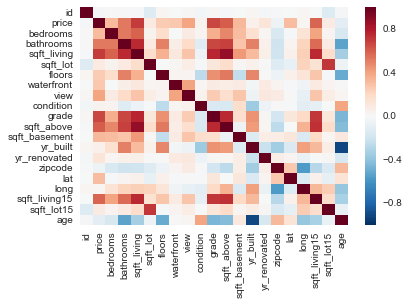

In [87]:
#See how they relate to each other
sns.heatmap(prices_df.corr())

In [88]:
prices_df['sqft_living_sqr'] = prices_df['sqft_living'] ** 2

In [89]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = prices_df['price'].values.reshape(-1, 1)
X = prices_df[['bedrooms', 'bathrooms', 'sqft_living_sqr', 'view', 'floors', 'age', 'grade', 'lat', 'waterfront']]
regr.fit(X, Y)

# Inspect the results.
correlation_matrix = X.corr()
display(correlation_matrix)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
score = cross_val_score(regr, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

,bedrooms,bathrooms,sqft_living_sqr,view,floors,age,grade,lat,waterfront
bedrooms,1.000,0.529,0.485,0.082,0.181,-0.171,0.367,-0.011,-0.007
bathrooms,0.529,1.000,0.673,0.188,0.501,-0.537,0.665,0.025,0.064
sqft_living_sqr,0.485,0.673,1.000,0.290,0.299,-0.275,0.691,0.056,0.120
view,0.082,0.188,0.290,1.000,0.029,0.018,0.251,0.006,0.402
floors,0.181,0.501,0.299,0.029,1.000,-0.505,0.458,0.050,0.024
age,-0.171,-0.537,-0.275,0.018,-0.505,1.000,-0.461,0.136,0.001
grade,0.367,0.665,0.691,0.251,0.458,-0.461,1.000,0.114,0.083
lat,-0.011,0.025,0.056,0.006,0.050,0.136,0.114,1.000,-0.014
waterfront,-0.007,0.064,0.120,0.402,0.024,0.001,0.083,-0.014,1.000



Coefficients: 
 [[ -1.83009269e+04   3.93333725e+04   3.05043582e-02   5.33431354e+04
    7.91888810e+03   2.32198288e+03   1.04038597e+05   5.75479460e+05
    5.81940607e+05]]

Intercept: 
 [-27935561.53233859]

R-squared:
0.709354366922
Accuracy: 0.70 (+/- 0.05)


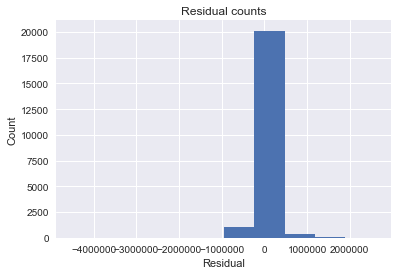

In [90]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = prices_df['price']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [91]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
df = pd.DataFrame(prices_df.bedrooms + prices_df.bathrooms + prices_df.sqft_living_sqr + prices_df.floors + prices_df.age)

X = df 
Y = prices_df.price
knn.fit(X, Y)



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [92]:
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.48 (+/- 0.08)
